In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
#1.PPI database
PPP_data = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\PPP_Projects_Total.csv")
#2.GDP per capita
GDP_per_capita = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP per Capita.csv")
#3.Tax as GDP
tax_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Tax as GDP.csv")
#4.GDP deflator(inflation rate)
GDP_deflator = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP deflator.csv")
#5.life expectnacy
life_expectnacy = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Life expectnacy.csv")
#6.real effective change
real_effective_change = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Real effect change.csv")
#7.electric consumption
electric_consumption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Electric consumption.csv")
#8.domestic credit to private
domestic_credit_to_private = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Domestic credit to private.csv")
#9.Import as GDP
imports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Imports as GDP.csv")
#10.Export as GDP
exports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Exports as GDP.csv")
#11.Control of corruption
control_of_corruption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Control of corruption.csv")
#12.Government of effectiveness
government_effectiveness = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Government effectiveness.csv")
#13.Political stability
political_stability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Political Stability and Absence of Violence.csv")
#14.regulatory quality
regulatory_quality = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Regulatory quality.csv")
#15.Rule of law
rule_of_law = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Rule of law.csv")
#16.voice and accountability
voice_and_accountability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Voice and accountability.csv")

In [3]:
dataset = [GDP_per_capita, 
           tax_as_GDP, 
           GDP_deflator, 
           life_expectnacy, 
           real_effective_change,
           electric_consumption,
           domestic_credit_to_private, 
           imports_as_GDP, 
           exports_as_GDP, 
           control_of_corruption,
           government_effectiveness, 
           political_stability, 
           regulatory_quality, 
           rule_of_law, 
           voice_and_accountability]

dataset_name = ['GDP_per_capita', 
                'tax_as_GDP', 
                'GDP_deflator', 
                'life_expectnacy', 
                'real_effective_change',
                'electric_consumption', 
                'domestic_credit_to_private', 
                'imports_as_GDP', 
                'exports_as_GDP', 
                'control_of_corruption',
                'government_effectiveness',
                'political_stability', 
                'regulatory_quality', 
                'rule_of_law', 
                'voice_and_accountability']

In [4]:
def process_data(new_data):
    new_data.drop(columns=['Series Name', 'Series Code', 'Country Name'], inplace=True)
    new_data.set_index('Country Code', inplace=True)
    new_data.dropna(how='all', inplace=True)
    new_data.columns = [name.split(' ')[0] for name in list(new_data.columns)]

for data in dataset:
    process_data(data)

def meltdata(raw_data, column_name):
    new_data = pd.melt(raw_data.reset_index(), 
                       id_vars=['Country Code'], 
                       var_name=['Year'],
                       value_vars=raw_data.columns,
                       value_name=column_name)
    new_data.Year = new_data.Year.astype('int64', copy=False)
    return new_data

for i,name in zip(np.arange(len(dataset)), dataset_name):
    dataset[i] = meltdata(dataset[i], name).copy()
    dataset[i].rename(columns={'Country Code': 'countrycode', 
                               'Year': 'IY'}, 
                      inplace=True)

for data in dataset:
    PPP_data= PPP_data.merge(data, 
                             left_on=['countrycode', 'IY'], 
                             right_on=['countrycode', 'IY'], 
                             how='left')

In [5]:
PPP_data.shape

(7096, 59)

In [13]:
PPP_data.isnull().sum() / PPP_data.shape[0] * 100

IY                              0.000000
country                         0.000000
Region                          0.000000
income                          0.000000
IDA                             0.000000
FCY                             0.000000
type                            0.000000
stype                           0.000000
status_n                        0.000000
sector                          0.000000
ssector                         0.000000
Segment                         0.000000
period                         26.972943
GGC                            19.447576
TIGS                           20.504510
private                         3.931793
physical                        4.439121
investment                      7.328072
pcapacity                      14.120631
bid_crit                      100.000000
PRS                             0.070462
BS                              4.072717
Description                     0.000000
PCO                             2.226607
UP              

In [9]:
PPP_data.Region.unique()

array(['LAC', 'EAP', 'SAR', 'AFR', 'ECA', 'MENA'], dtype=object)

In [787]:
float_value = ['GDP_per_capita', 
               'tax_as_GDP', 
               'GDP_deflator', 
               'life_expectnacy', 
               'real_effective_change',
               'electric_consumption', 
               'domestic_credit_to_private', 
               'imports_as_GDP', 
               'exports_as_GDP', 
               'control_of_corruption',
               'government_effectiveness', 
               'political_stability', 
               'regulatory_quality', 
               'rule_of_law', 
               'voice_and_accountability']
nominal_value = ['IDA', 
                 'Region',
                 'type', 
                 'stype', 
                 'sector',
                 'Segment', 
                 'UP', 
                 'PublicDisclosure', 
                 'shareborder', 
                 'PRS', 
                 'Renewables', 
                 'MLS', 
                 'GGC',
                 'lendingtype']
ordinal_value = ['incomelevel']
float_value_2 = ['period', 
                 'realphysicalassets', 
                 'investment_real', 
                 'GDP', 
                 'population', 
                 'CPI2019',
                 'bordercountries', 
                 'private', 
                 'physical', 
                 'period',
                 'investment', 
                 'pcapacity']
PPP_data.drop(columns=['bid_crit', 
                       'region',
                       'Description', 
                       'incomelevelname',
                       'lendingtypename',
                       'regionname',
                       'adminregionname', 
                       'BS', 
                       'income',
                       'TIGS',
                       'ssector',
                       'PCO', 
                       'FCY',
                       'country', 
                       'adminregion'], inplace=True)

PPP_data.replace('..', np.nan, inplace=True)
PPP_data.replace({'status_n': {'Cancelled': 'fail', 
                               'Distressed': 'fail', 
                               'Active': 'success',
                               'Concluded': 'success'}}, inplace=True)

for float_column in float_value + float_value_2:
    PPP_data[float_column] = PPP_data[float_column].astype(float)

In [788]:
#split the data
X = PPP_data[PPP_data.columns[PPP_data.columns!='status_n']]
y = PPP_data['status_n']
#income value is ordinal value
mapper = {'LIC': 1, 
          'HIC': 2, 
          'LMC': 3, 
          'UMC': 4, 
          np.nan: 0}
X.loc[:, 'incomelevel'] = X.incomelevel.map(mapper)
y = LabelEncoder().fit_transform(y)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [789]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state=123, stratify=y, shuffle=True)

In [695]:
#to resample data
X_train['status_n'] = y_train

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [696]:
#begin to resample
majority_data = X_train[X_train.status_n==1]
minority_data = X_train[X_train.status_n==0]

minority_upsampled = resample(minority_data, 
                              replace=True,
                              n_samples=majority_data.shape[0],
                              random_state=123)
upsampled_data = pd.concat([majority_data, minority_upsampled])

X_train = upsampled_data[upsampled_data.columns[upsampled_data.columns!='status_n']]
y_train = upsampled_data['status_n']

In [697]:
#first fillna for training dataset based on country, if some countries are non, then fill with the mode in current column, the same for test dataset.
def fillna_for_nominal(column_name, train_dataset, test_dataset):
    train_data = train_dataset.copy()
    test_data = test_dataset.copy()
    mode_in_train = train_data.groupby('countrycode')[column_name].agg(pd.Series.mode).to_frame()
    for index, row in mode_in_train.iterrows():
        if type(row[column_name]) == np.ndarray:
            mode_in_train.loc[index, column_name] = train_data[column_name].mode()[0]
    countrycode_in_train = train_data.countrycode.unique()
    countrycode_in_test = train_data.countrycode.unique()
    
    for country in countrycode_in_train:
        train_data.loc[train_data.countrycode==country, column_name] = train_data.loc[train_data.countrycode==country, column_name].fillna(mode_in_train.loc[country, column_name])

    for country in countrycode_in_test:
        if country in countrycode_in_train:
            test_data.loc[test_data.countrycode==country, column_name] = test_data.loc[test_data.countrycode==country, column_name].fillna(mode_in_train.loc[country, column_name])
    test_data.loc[test_data[column_name].isnull(), column_name] = test_data.loc[test_data[column_name].isnull(), column_name].fillna(test_data[column_name].mode()[0])
    return train_data, test_data

In [698]:
nominal_list = ['GGC', 'PRS', 'lendingtype']
for name in nominal_list:
    X_train, X_test = fillna_for_nominal(name, X_train, X_test)

In [699]:
def fillna_for_float(column_name, train_dataset, test_dataset):
    train_data = train_dataset.copy()
    test_data = test_dataset.copy()
    mean_in_train = train_data.groupby('countrycode')[column_name].agg(pd.Series.mean).to_frame()
    for index, row in mean_in_train.iterrows():
        mean_in_train.loc[index, column_name] = train_data[column_name].mean()
    countrycode_in_train = train_data.countrycode.unique()
    countrycode_in_test = train_data.countrycode.unique()
    
    for country in countrycode_in_train:
        train_data.loc[train_data.countrycode==country, column_name] = train_data.loc[train_data.countrycode==country, column_name].fillna(mean_in_train.loc[country, column_name])

    for country in countrycode_in_test:
        if country in countrycode_in_train:
            test_data.loc[test_data.countrycode==country, column_name] = test_data.loc[test_data.countrycode==country, column_name].fillna(mean_in_train.loc[country, column_name])
    test_data.loc[test_data[column_name].isnull(), column_name] = test_data.loc[test_data[column_name].isnull(), column_name].fillna(test_data[column_name].mean())
    return train_data, test_data

In [700]:
for name in float_value + float_value_2:
    X_train, X_test = fillna_for_float(name, X_train, X_test)

In [701]:
#delete unused column
X_train.drop(columns=['IY', 'countrycode'], inplace=True)
X_test.drop(columns=['IY', 'countrycode'], inplace=True)

In [702]:
X_test.isnull().sum()

Region                        0
IDA                           0
type                          0
stype                         0
sector                        0
Segment                       0
period                        0
GGC                           0
private                       0
physical                      0
investment                    0
pcapacity                     0
PRS                           0
UP                            0
PublicDisclosure              0
bordercountries               0
shareborder                   0
incomelevel                   0
lendingtype                   0
GDP                           0
population                    0
CPI2019                       0
investment_real               0
realphysicalassets            0
Renewables                    0
MLS                           0
GDP_per_capita                0
tax_as_GDP                    0
GDP_deflator                  0
life_expectnacy               0
real_effective_change         0
electric

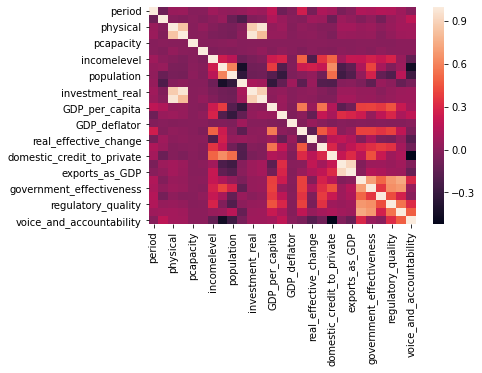

In [703]:
sns.heatmap(X_train.corr())

In [704]:
#delete the correlated columns
correlated_column = ['exports_as_GDP', 'physical', 'realphysicalassets', 'investment_real', 'GDP']
X_train.drop(columns=correlated_column, inplace=True)
X_test.drop(columns=correlated_column, inplace=True)

In [782]:
X_train

array([[ 0.        ,  0.48403446, -0.15284077, ..., -0.18297564,
        -0.29239197, -0.05274127],
       [ 0.52486535,  0.48403446, -0.27496549, ..., -0.18297564,
        -0.29239197, -0.05274127],
       [ 0.52486535,  0.48403446,  0.72986015, ..., -0.18297564,
        -0.29239197, -0.05274127],
       ...,
       [ 2.3667    ,  0.48403446,  0.        , ..., -0.18297564,
        -0.29239197, -0.05274127],
       [ 0.81568135, -1.23986231,  0.16023859, ..., -0.18297564,
        -0.29239197, -0.05274127],
       [-0.92921464,  0.48403446, -0.42685408, ..., -0.18297564,
        -0.29239197, -0.05274127]])

In [705]:
column_name = X_train.columns

In [706]:
#to make sure the train and test dataset have the same shape
train_objs_num = len(X_train)
combine_dataset = pd.concat(objs=[X_train, X_test], axis=0)
dataset_preprocessed = pd.get_dummies(combine_dataset, columns=nominal_value)
X_train = dataset_preprocessed[:train_objs_num]
X_test = dataset_preprocessed[train_objs_num:]

In [708]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

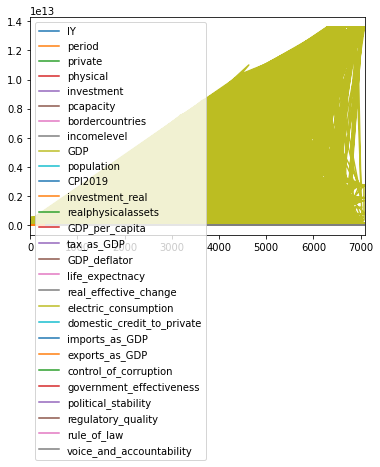

In [772]:
clf = RandomForestClassifier(random_state=1)
param_grid = {'n_estimators': [200, 300, 400, 500],
              'max_features': ['auto', 'sqrt'], 
              'max_depth': [25, 28, 30, 40],
              'min_samples_split': [5, 8, 10],
              'min_samples_leaf': [5, 8, 10]}
grid = GridSearchCV(clf, 
                    param_grid, 
                    refit=True, 
                    verbose=3, 
                    n_jobs=-1)

grid.fit(X_train, y_train)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 288 candidates, totalling 864 fits


ValueError: Invalid parameter max_depth for estimator CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=None,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                                                             min_weight_fraction_leaf=0.0,
                                                             n_estimators='warn',
                                                             n_jobs=None,
                                                             oob_score=False,
                                                             random_state=1,
                                                             verbose=0,
                                                             warm_start=False),
                       cv='warn', method='isotonic'). Check the list of available parameters with `estimator.get_params().keys()`.

In [774]:
clf_1 = RandomForestClassifier(max_depth=28, 
                               max_features='auto', 
                               min_samples_leaf=5,
                               min_samples_split=5,
                               n_estimators=500,
                               random_state=1)
clf_isotonic = CalibratedClassifierCV(clf_1, method='isotonic')
clf_isotonic.fit(X_train, y_train)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=28,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=5,
                                                             min_weight_fraction_leaf=0.0,
                                                             n_estimators=500,
                  

In [726]:
grid.best_params_

{'max_depth': 28,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 500}

In [727]:
#clf directly
pred = cross_val_predict(grid.best_estimator_,
                         X_test,
                         y_test,
                         method='predict_proba',
                         cv=5)

In [775]:
#calibration
pred = cross_val_predict(clf_isotonic,
                         X_test,
                         y_test,
                         method='predict_proba',
                         cv=5)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\mo

In [712]:
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return (fpr, tpr, thresholds)

(array([0.        , 0.01388889, 0.01388889, 0.04166667, 0.04166667,
        0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
        0.04166667, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
        0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
        0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
        0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.08333333,
        0.08333333, 0.08333333, 0.09722222, 0.09722222, 0.09722222,
        0.09722222, 0.09722222, 0.09722222, 0.09722222, 0.09722222,
        0.09722222, 0.09722222, 0.09722222, 0.09722222, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11

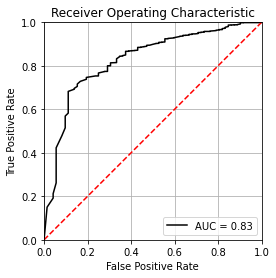

In [776]:
plot_roc(y_test, pred[:,1])

In [777]:
import seaborn as sns
def plot_cm(labels, predictions, p=0.8):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [780]:
confusion_matrix(y_test, pred[:, 1] > 0.9)

array([[  38,   34],
       [ 188, 1585]], dtype=int64)

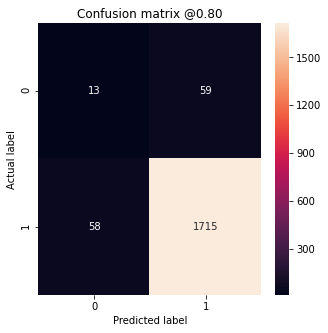

In [781]:
plot_cm(y_test, pred[:, 1])

In [756]:
y_test.sum()

1773

In [755]:
#feature importance
fi = pd.DataFrame({'feature': list(column_name),
                   'importance': clf.feature_importances_}).\
                    sort_values('importance', ascending = False)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [539]:
fi.head(20)

,feature,importance
7,CPI2019,0.089133
2,investment,0.058594
3,pcapacity,0.050515
6,population,0.050153
17,government_effectiveness,0.039719
11,life_expectnacy,0.037919
8,GDP_per_capita,0.036504
21,voice_and_accountability,0.036159
96,PRS_Purchase Agreements (private & public),0.032692
0,period,0.031650
